# COMP9517 Assignment

In [1]:
# import libraries

import cv2
import numpy as np
from matplotlib import pyplot as plt



## Task 1

1- OTSU thresholding method:

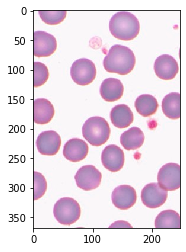

In [2]:
# load and show image
img = cv2.imread('c3.jpg')

plt.imshow(img)

In [3]:
# implementation of otsu's thersholding method
def otsu(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    pixel_number = gray.shape[0] * gray.shape[1]
    mean_weight = 1.0/pixel_number
    his, bins = np.histogram(gray, np.arange(0,257))
    final_thresh = -1
    final_value = -1
    intensity_arr = np.arange(256)
    
    for t in bins[1:-1]: # iterate through bins in histogram
        # fractions of upper and lower pixils intensities based on histogram
        pcb = np.sum(his[:t])
        pcf = np.sum(his[t:])
        # weights of upper and lower
        Wb = pcb * mean_weight
        Wf = pcf * mean_weight

        # mean intensities of pixils in lower and upper class
        mub = np.sum(intensity_arr[:t]*his[:t]) / float(pcb)
        muf = np.sum(intensity_arr[t:]*his[t:]) / float(pcf)
        
        # inter-class variance to be maximised
        value = Wb * Wf * (mub - muf) ** 2

        if value > final_value:
            final_thresh = t
            final_value = value
    
    final_img = gray.copy()
    print('OTSU Threshold:',final_thresh)
    final_img[gray > final_thresh] = 255
    final_img[gray < final_thresh] = 0
    #flip the pixils
    final_img = (final_img/255-1)*-255
    
    return final_img




OTSU Threshold: 202


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


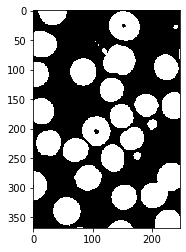

In [4]:
img_processed_otsu = otsu(img)
plt.imshow(img_processed_otsu, cmap='gray')

2- HSV thresholding:

In [5]:
# HSV Thresholding
img3 = cv2.imread('c3.jpg')
img_HSV = cv2.cvtColor(img3, cv2.COLOR_BGR2HSV)

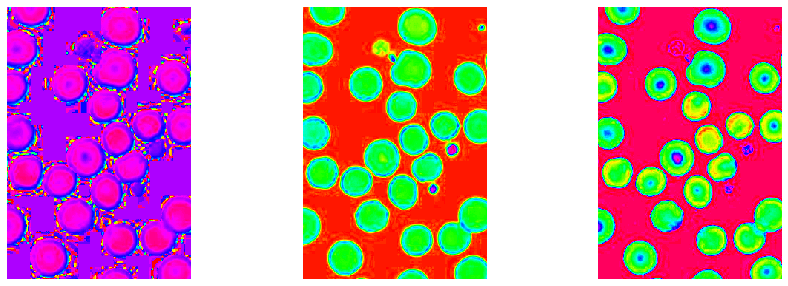

In [6]:
# see each channel
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(img_HSV[:,:,0], cmap='hsv')
ax[1].imshow(img_HSV[:,:,1], cmap='hsv')
ax[2].imshow(img_HSV[:,:,2], cmap='hsv')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

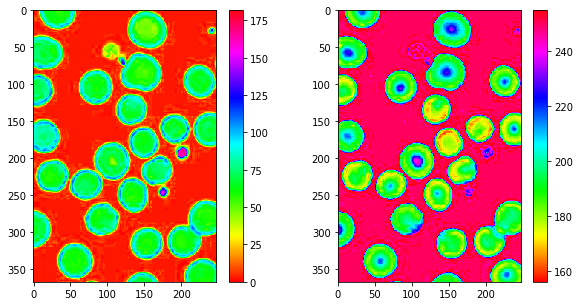

In [7]:
# see which channel to use for thresholding
# use colorbar to determine value
fig, ax = plt.subplots(1,2, figsize=(10,5))
im = ax[0].imshow(img_HSV[:,:,1],cmap='hsv')
fig.colorbar(im,ax=ax[0])
im2 = ax[1].imshow(img_HSV[:,:,2],cmap='hsv')
fig.colorbar(im2,ax=ax[1])
plt.show()

In [8]:
# HSV thresholding process into a function
def HSVthreshold(image):

    img_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # saturation (third channel) seems to give the best separation
    # based on the colorbar
    mask1 = img_HSV[:,:,1] > 20
    mask2 = img_HSV[:,:,1] < 160
    mask3 = mask1 * mask2
    # use the original image channels
    R = image[:,:,0]*mask3
    G = image[:,:,1]*mask3
    B = image[:,:,2]*mask3
    imgcut = np.dstack((R,G,B))
    # convert to grayscale
    imgcut_gray = cv2.cvtColor(imgcut, cv2.COLOR_BGR2GRAY)
    # threshold
    imgcut_gray[imgcut_gray>50] = 255
    
    print('HSV saturation: 160 > cell > 20')
    print('HSV gray threshold: 50')
    
    return imgcut_gray



HSV saturation: 160 > cell > 20
HSV gray threshold: 50


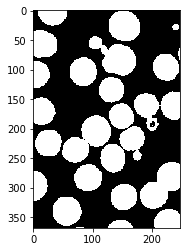

In [9]:
img_processed_HSV = HSVthreshold(img3)
plt.imshow(img_processed_HSV, cmap='gray')

In [10]:
def Task1(image):
    
    OTSU = otsu(image)
    
    HSV = HSVthreshold(image)
    
    # plot all images
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].imshow(image)
    ax[1].imshow(OTSU, cmap='gray')
    ax[2].imshow(HSV, cmap='gray')
    ax[0].title.set_text('input image')
    ax[1].title.set_text("otsu's method")
    ax[2].title.set_text('HSV method')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    plt.show()
    
    cv2.imwrite('OTSU.jpg', OTSU)
    cv2.imwrite('HSV.jpg', HSV)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


OTSU Threshold: 202
HSV saturation: 160 > cell > 20
HSV gray threshold: 50


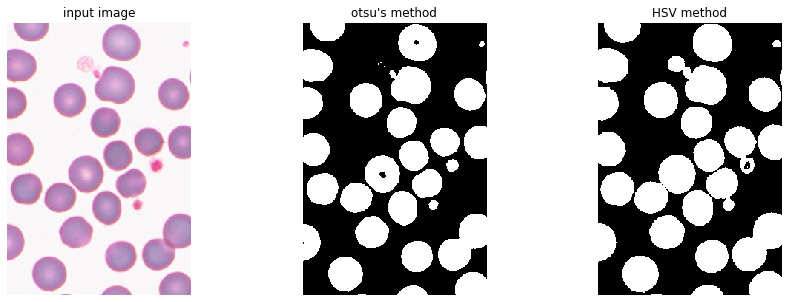

In [11]:
Task1(img)

## Task 2

1- applying the median filter

In [12]:
# apply the median filter on binary images from task 1

def MedianFilter(image, kernel=np.ones((5,5)), padding=0):
    

    # size of each matrix
    xKSize = kernel.shape[0]
    yKSize = kernel.shape[1]
    xImgSize = image.shape[0]
    yImgSize = image.shape[1]

    # size of the output
    xOutput = int(((xImgSize - xKSize + 2 * padding)) + 1)
    yOutput = int(((yImgSize - yKSize + 2 * padding)) + 1)
    output = np.zeros((xOutput, yOutput))

    # apply zero padding
    imagePadded = np.pad(image, 1, mode='constant')

    # convolution
    for y in range(image.shape[1]):
        # stop convolution when done
        if y > image.shape[1] - yKSize:
            break
        for x in range(image.shape[0]):
            # next row
            if x > image.shape[0] - xKSize:
                break
            output[x, y] = np.median((kernel * imagePadded[x: x + xKSize, y: y + yKSize]))
            
                    
    return output

2- cell count

In [49]:
# Connected component labeling
# takes a binary image and returns the number of cells in it

def CellCount(image, min_area = 300, overlap_area = 2300):
    # first pass
    copy = image.copy()
    copy[copy<200]=0
    copy[copy>200]=1
    image[image>200]=255
    image[image<200]=0
    #print(copy)
    D = {}
    label = 2
    l = [0,1]
    for i in range(len(image[:,0])):
        for j in range(len(image[0])):
            if image[i,j] != 0:
                if j != 0:
                    if i != 0:
                        if copy[i-1,j] not in l and copy[i,j-1] not in l:
                            if min(copy[i-1,j],copy[i,j-1]) in D.keys():
                                copy[i,j] = D[min(copy[i-1,j],copy[i,j-1])]
                                D.update({max(copy[i-1,j],copy[i,j-1]):D[min(copy[i-1,j],copy[i,j-1])]})
                            else:
                                copy[i,j] = min(copy[i-1,j],copy[i,j-1])
                                D.update({max(copy[i-1,j],copy[i,j-1]):min(copy[i-1,j],copy[i,j-1])})
                        if copy[i-1,j] not in l and copy[i,j-1] in l:
                            copy[i,j] = copy[i-1,j]
                        if copy[i-1,j] in l and copy[i,j-1] not in l:
                            copy[i,j] = copy[i,j-1]
                        if copy[i-1,j] in l and copy[i,j-1] in l:
                            copy[i,j] = label
                            label +=1
                    else:
                        if copy[i,j-1] not in l:
                            copy[i,j] = copy[i,j-1]
                        else:
                            copy[i,j] = label
                            label +=1
                else:
                    if i == 0:
                        copy[i,j] = label
                        label +=1
                    else:
                        if copy[i-1,j] not in l:
                            copy[i,j] = copy[i-1,j]
                        else:
                            copy[i,j] = label
                            label +=1
            else:
                continue

    # second pass
    for i in range(len(image[:,0])):
        for j in range(len(image[0])):
            if image[i,j] != 0:
                if copy[i,j] in D.keys():
                    copy[i,j] = D[copy[i,j]]



    unique, frequency = np.unique(copy, return_counts = True) 
    
    n = len(frequency[frequency>min_area])-1+len(frequency[frequency>overlap_area])-1
    
    cv2.imwrite(str(n)+'.jpg',image)
    
    return n



In [ ]:
def Task2single(img):
    # apply median filter then cell count

    img_med = MedianFilter(img)
    count = CellCount(img_med)
    
    
    plt.imshow(img_med, cmap='gray')
    

    
    return count

In [42]:

def Task2(img_processed_otsu, img_processed_HSV):
    # apply median filter then cell count

    img_med_otsu = MedianFilter(img_processed_otsu)
    count_otsu = CellCount(img_med_otsu)
    
    img_med_HSV = MedianFilter(img_processed_HSV)
    count_HSV = CellCount(img_med_HSV)

    
    return count_otsu, count_HSV
    

In [43]:
def compare():
    
    for i in range(4):
        img = cv2.imread('c'+str(i+1)+'.jpg')
        OTSU = otsu(img)
        HSV = HSVthreshold(img)
        count_otsu, count_HSV = Task2(OTSU, HSV)
        print('c'+str(i+1)+'.jpg')
        print('Count otsu:', count_otsu)
        print('Count HSV', count_HSV)


In [50]:
compare()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


OTSU Threshold: 202
HSV saturation: 160 > cell > 20
HSV gray threshold: 50
c1.jpg
Count otsu: 58
Count HSV 58
OTSU Threshold: 202
HSV saturation: 160 > cell > 20
HSV gray threshold: 50
c2.jpg
Count otsu: 38
Count HSV 38
OTSU Threshold: 202
HSV saturation: 160 > cell > 20
HSV gray threshold: 50


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


c3.jpg
Count otsu: 24
Count HSV 25
OTSU Threshold: 202
HSV saturation: 160 > cell > 20
HSV gray threshold: 50
c4.jpg
Count otsu: 30
Count HSV 30
